<a href="https://colab.research.google.com/github/Geosb/Classifier-for-predicting-loan-outcome/blob/master/imageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN IMAGE CLASSIFICATION WITH KERAS AND TENSOR FLOW IN PYTHON

1. CREATE A ROOT FOLDER: ImageClassification
2. create three other sub folder within:
data, logs, and imageclassification.
3. within data sub folder create two other subfolders:
happy and sad
4. upload the happy and sad zip files

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
!pip install tensorflow tensorflow gpu python matplotlib

ERROR: Could not find a version that satisfies the requirement gpu (from versions: none)
ERROR: No matching distribution found for gpu


In [2]:
#pip list

In [3]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import numpy as np

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.14.0


In [4]:
from matplotlib import pyplot as plt
import cv2
import os

In [5]:
# Clear any logs from previous runs
#rm -rf /content/ImageClassification/logs

In [6]:
# Limit memory usage to avoid out-of-memory error
gpu = tf.config.experimental.list_physical_devices('GPU')
for device in gpu:
  tf.config.experimental.set_memory_growth(device, True)

Unzip our images into data diretory

In [7]:
# import os

# dir = '/content/ImageClassification/data'
# for f in os.listdir(dir):
#     os.remove(os.path.join(dir, f))

In [ ]:
!unzip /content/ImageClassification/happy.zip -d /content/ImageClassification/data/happy
!unzip /content/ImageClassification/sad.zip -d /content/ImageClassification/data/sad

Remove doggy images

In [9]:
data = '/content/ImageClassification/data'
folder = '/content/ImageClassification/data/happy'
image = '05-12-21-happy-people.jpg'
img = cv2.imread(os.path.join(data, folder, image))
img.shape

(880, 1400, 3)

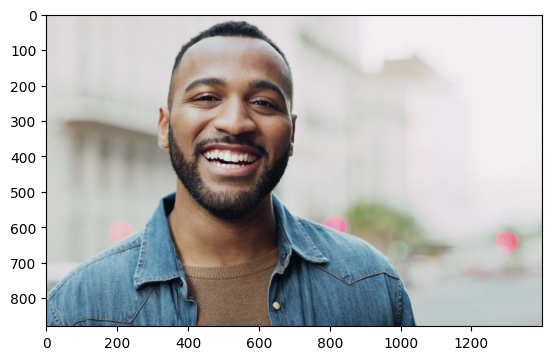

In [10]:
#plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
#os.listdir(data_dir)
#os.listdir(os.path.join(data_dir, 'happy'))

In [12]:
import imghdr

data_dir = '/content/ImageClassification/data'
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for img_class in os.listdir(data_dir): # iterate content of 'data' directory
  for img in os.listdir(os.path.join(data_dir, img_class)): # iterate through our images
    img_path = os.path.join(data_dir, img_class, img)
    try:
      image = cv2.imread(img_path)
      tip = imghdr.what(img_path)
      if tip not in img_exts: # check if image has our expected extentions
        print("Image not in existing list {}".format(img_path))
        os.remove(img_path) # remove image not in extention ['jpeg', 'jpg', 'bmp', 'png']
    except Exception as e:
      print("issue with image {}".format(img_path))
      # os.remove(img_path)


In [22]:
# checking if our data is balanced
happy_dir = '/content/ImageClassification/data/happy'
sad_dir = '/content/ImageClassification/data/sad'
print(len([name for name in os.listdir(happy_dir) if os.path.isfile(os.path.join(happy_dir, name))]))
print(len([name for name in os.listdir(sad_dir) if os.path.isfile(os.path.join(sad_dir, name))]))

154
140


LOAD DATASET

In [23]:
# for documentation
tf.data.Dataset?

In [24]:
import numpy as np
# import API pipeline for building image class with labels and  out-of-the-box preprocessing
#tf.keras.utils.image_dataset_from_directory??

In [25]:
data_dir = '/content/ImageClassification/data'
# NB to configure image size you can do:
#tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=16,
#                                            image_size=(128,128))
# Build our pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 294 files belonging to 2 classes.


In [26]:
type(data)
data #.shuffle(294)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
# creating Access to our pipeline
# NB our result is generator not a file in memory
# To look at our data we need a numpy iterator
data_iter = data.as_numpy_iterator()

In [35]:
# Accesssing the pipeline batch by batch
print(data_iter)
batch = data_iter.next()
print(len(batch)) # collections of images and shape
# images represented as numpy arrays
print(batch[0].shape)
# labels 0 --> happy, 1 --> sad
print(batch[1])

2
(32, 256, 256, 3)
[0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1]


so our pipeline helper/ utility function has reshaped our data to a batch size of 32 allowing for consistency

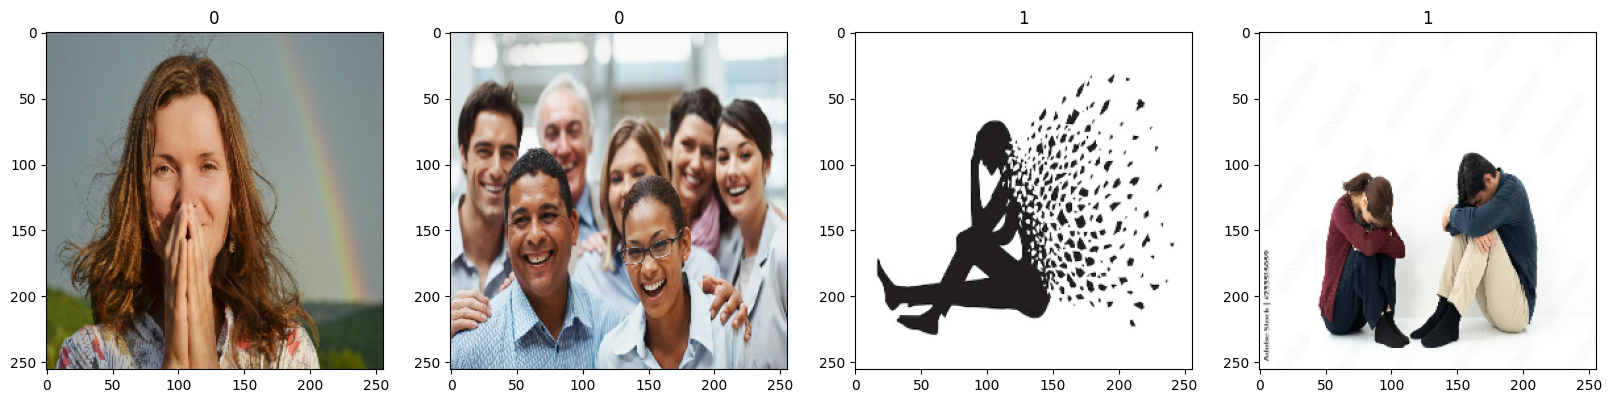

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

DATA PREPROCESSING

[Tensorflow documentatin:](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbjlOdHBhVXYyN2kzYlpGQ083eWlPajdfN2JfUXxBQ3Jtc0trc01vZktOQksyVzh0UUltdS1PLWdQd1ZLSHRFUjVmSEtGc09RUktkelRuRlktdjJUaWpYeUpnc2hpb2lqdEpfNHRsVzI3WnJweDdwdmw0NzFmWXhvZFItQXB3UEJKdmJvUXpXUlF6bDN3MVNST0p3Zw&q=https%3A%2F%2Fwww.tensorflow.org%2Fapi_docs%2Fpython%2Ftf%2Fkeras%2Flayers%2FConv2D&v=jztwpsIzEGc)

Data Scaling: we scale our data (i.e put it within 0 & 1) within the pipeline to increase processing

In [37]:
# Before scaling
print(data.as_numpy_iterator().next()[0].max())
print(data.as_numpy_iterator().next()[0].min())

255.0
0.0


In [38]:
# Scaling within the pipeline
data = data.map(lambda x, y: (x/255, y))

In [39]:
# After scaling
print(data.as_numpy_iterator().next()[0].max())
print(data.as_numpy_iterator().next()[0].min())

1.0
0.0


Split Data

In [40]:
len(data) # batch size

10

In [41]:
train_data = int(len(data)*.7)
validation_data = int(len(data)*.2)
test_data = int(len(data)*.1)

In [42]:
train_data + validation_data + test_data

10

You shuffle the data before picking tarin, validationa nd test data

In [43]:
train = data.take(train_data)
val = data.skip(train_data).take(validation_data)
test = data.skip(train_data + validation_data).take(test_data)

In [44]:
#train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [45]:
# x_train = train

In [46]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(train, val, test_size = 0.3, random_state = 45)
# print("x_train shape",x_train.shape)
# print("x_test shape",x_val.shape)
# print("y_train shape",y_train.shape)
# print("y_test shape",y_val.shape)

BUILD THE DEEP LEARNING MODEL

We're using sequential tensorflow model (in keras) API because we have single flow of data input and single output. If you have multiple input and multiple output, you could use Function API
[You can read](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

explanation of layers:
1st. Input Layer - convolution with:

16 - no. of filters to extract important features from out image for output classification.

(3,3) - Size of filters three pixel by three pixels, and

1 - a stride of one.

Relu - The activation layer to change our shape.

(256,256,3) - input of 256 height, 256 breadth and 3 channels deep (color range).

MaxPoling2D - To condense the output results by a half. 256/2

Flatten() is normalization. we condense our input into a single dimension (30 * 30 * 16) = 14444

Dense() - fully connected layer with 256 neurons and end up with just one output layer

In [47]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import itertools

model = keras.Sequential()

In [48]:
#model = Sequential()

In [49]:
# Input layer
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#model.add(tf.keras.layers.Conv2D(input_shape = (256,256,3), filters = 32,
#                                 kernel_size = (3,3),
#                                 activation = "relu", padding = "same" ))
model.add(MaxPool2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [50]:
#model.add(tf.keras.layers.Conv2D(input_shape = (32,32,3), filters = 8, kernel_size = (5,5),activation = "relu", padding = "same" ))

In [51]:
#tf.optimizers.
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [52]:
# model.compile(optimizer = 'adam',
#               loss=tf.losses.BinaryCrossentropy(),
#               metrics=['accracy'])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

TRAINING

In [54]:
# create a log directory for recording events of train and validation runs
log_dir = '/content/ImageClassification/logs/batch_level/' + datetime.now().strftime("%Y%m%d-%H%M%S") + '/train'

In [55]:
# creating logs for looking up how our models worked
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [56]:
#log_dir = 'logs/batch_level/' + datetime.now().strftime("%Y%m%d-%H%M%S") + '/train'
#train_writer = tf.summary.create_file_writer(log_dir)

In [58]:
# fit() is training component
# predict() is prediction component
# epochs how long we're going to train our data
# validation - for validation
# train.shuffle() shuffles each batch before fiting
# Callbacks records logs
hist = model.fit(train.shuffle(294),
                 epochs=20,
                 validation_data=val,
                 callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 21s 850ms/step - loss: 1.9181 - accuracy: 0.4554 - val_loss: 0.6782 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 11s 814ms/step - loss: 0.6572 - accuracy: 0.5312 - val_loss: 0.6500 - val_accuracy: 0.6719
Epoch 3/20
7/7 [==============================] - 11s 897ms/step - loss: 0.6441 - accuracy: 0.7098 - val_loss: 0.5874 - val_accuracy: 0.7500
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 0.5700 - accuracy: 0.7589 - val_loss: 0.5399 - val_accuracy: 0.7500
Epoch 5/20
7/7 [==============================] - 11s 1s/step - loss: 0.5341 - accuracy: 0.7545 - val_loss: 0.4554 - val_accuracy: 0.7812
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 0.5348 - accuracy: 0.7366 - val_loss: 0.5524 - val_accuracy: 0.7031
Epoch 7/20
7/7 [==============================] - 11s 1s/step - loss: 0.4909 - accuracy: 0.7589 - val_loss: 0.5265 - val_accuracy: 0.7031
Epoch 8/20
7/7 [=========

In [ ]:
hist.history

PLOT PERFORMANCE

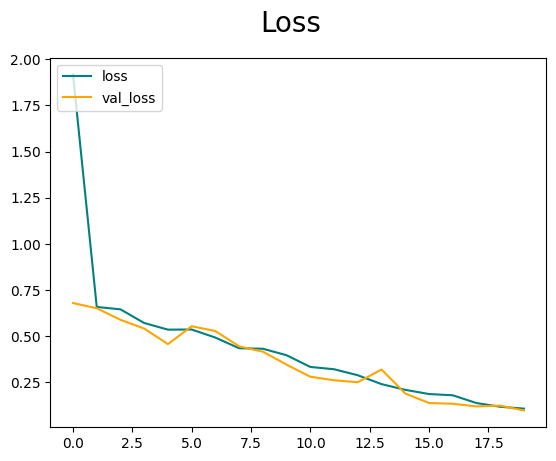

In [60]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

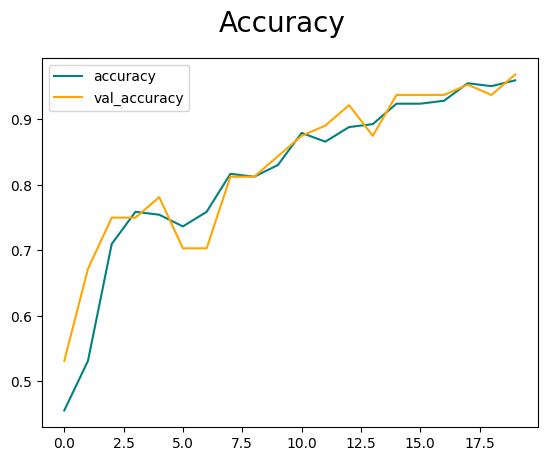

In [61]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

EVALUATE PERFORMANCE

In [62]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [63]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [64]:
len(test)

1

In [65]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 231ms/step


In [66]:
print(f'Precision:{pre.result().numpy()}')
print(f'Recall:{re.result().numpy()}')
print(f'Accuracy:{acc.result().numpy()}')

Precision:1.0
Recall:1.0
Accuracy:1.0


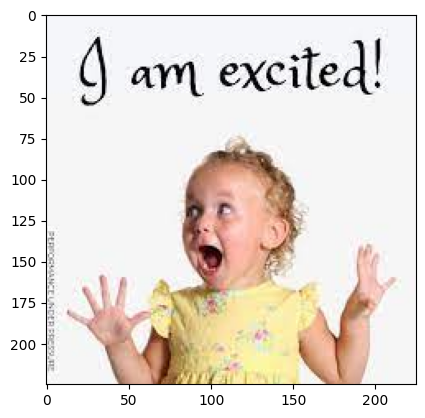

In [115]:
img = cv2.imread('/content/ImageClassification/happy_baby.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

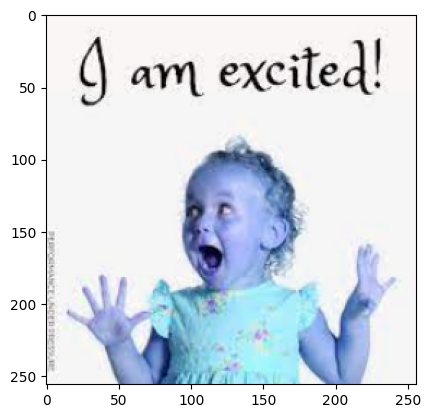

In [116]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [117]:
resize.shape

TensorShape([256, 256, 3])

In [118]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [119]:
yhat = model.predict(np.expand_dims(resize/256, 0))

1/1 [==============================] - 0s 19ms/step


In [120]:
yhat

array([[0.1516322]], dtype=float32)

In [121]:
if yhat > 0.5:
  print(f"Prediction class is Sad")
else:
  print(f'The prediction is Happy')

The prediction is Happy


SAVE THE MODEL

In [122]:
from tensorflow.keras.models import load_model

model.save(os.path.join('/content/ImageClassification/models', 'happy_sad_ic_model.h5'))

In [123]:
new_model = load_model(os.path.join('/content/ImageClassification/models', 'happy_sad_ic_model.h5'))

In [124]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 84ms/step


In [125]:
if yhat_new > 0.5:
  print(f"Prediction class is Sad")
else:
  print(f'The prediction is Happy')

The prediction is Happy
